# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [5]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [35]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)

        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b

        if activation != 0:
            return tf.nn.softmax(y)
        return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=0)
    return x3

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов


In [36]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность

def accuracy(y_pred, y_true):
  # Порівнюємо передбачені значення з істинними та підраховуємо кількість правильних відповідей
  acc = tf.metrics.Accuracy()

  # Перетворюємо булеві значення в числа (0 або 1) та обчислюємо середню точність
  acc.update_state(y_true, tf.argmax(y_pred, axis=1))
  return acc.result()

In [37]:
from keras.src.backend import gradients
from tensorflow.python.ops.variables import trainable_variables
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_vars = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_vars)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_vars))

In [38]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step {step}, Loss: {current_loss}, Accuracy: {acc}")

print("Training Finished!")

Step 0, Loss: 987.2268676757812, Accuracy: 0.125
Step 100, Loss: 0.8197593688964844, Accuracy: 0.12890625
Step 200, Loss: 1.0130140781402588, Accuracy: 0.1328125
Step 300, Loss: 0.2057221531867981, Accuracy: 0.11328125
Step 400, Loss: 0.4188081622123718, Accuracy: 0.14453125
Step 500, Loss: 0.05701715499162674, Accuracy: 0.11328125
Step 600, Loss: 0.5593762397766113, Accuracy: 0.1640625
Step 700, Loss: 0.020557530224323273, Accuracy: 0.17578125
Step 800, Loss: 0.06289844214916229, Accuracy: 0.10546875
Step 900, Loss: 0.036052972078323364, Accuracy: 0.15234375
Step 1000, Loss: 0.021511033177375793, Accuracy: 0.15234375
Step 1100, Loss: 0.05290808528661728, Accuracy: 0.12890625
Step 1200, Loss: 0.025179525837302208, Accuracy: 0.171875
Step 1300, Loss: 0.011292852461338043, Accuracy: 0.171875
Step 1400, Loss: 0.011299746111035347, Accuracy: 0.1953125
Step 1500, Loss: 0.05357782542705536, Accuracy: 0.1796875
Step 1600, Loss: 0.009496417827904224, Accuracy: 0.1640625
Step 1700, Loss: 0.0750

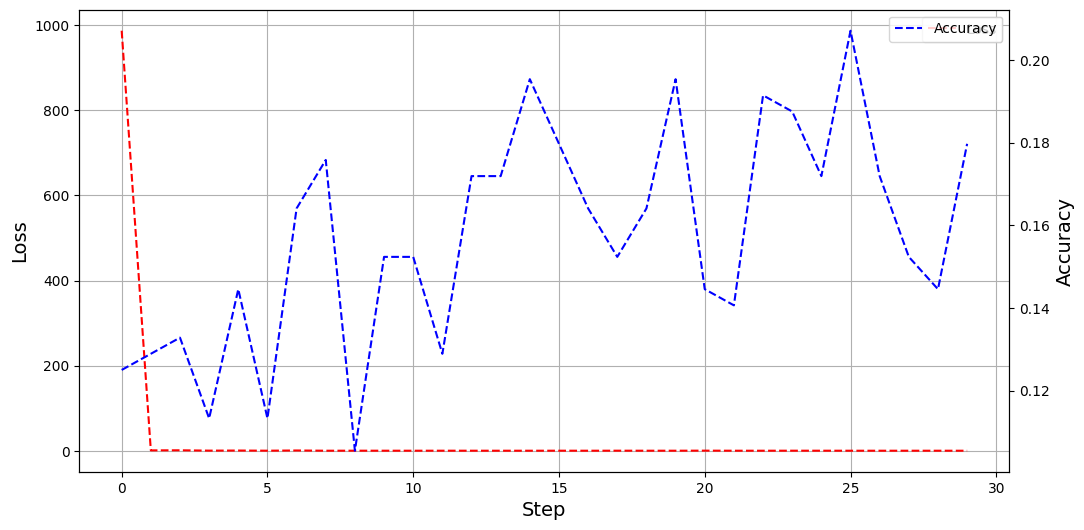

In [49]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

import pandas as pd
import matplotlib.pyplot as plt

# Створюємо DataFrame з даними
data = pd.DataFrame({'Loss': loss_history, 'Accuracy': accuracy_history})

# Створюємо фігуру та область підграфіка
fig, axs = plt.subplots(figsize=(12, 6))

# Графік втрат
axs.plot(data['Loss'], label='Loss', color='r', linestyle="--")
axs.set_xlabel('Step', fontsize=14)
axs.set_ylabel('Loss', fontsize=14)
axs.legend()
axs.grid(True)

# Створюємо ще одну область підграфіка для точності
axs2 = axs.twinx()
axs2.plot(data['Accuracy'], label='Accuracy', color='b', linestyle="--")
axs2.set_ylabel('Accuracy', fontsize=14)
axs2.legend()

plt.show()


In [50]:
# Вычислите точность обученной нейросети

from sklearn.metrics import accuracy_score

# Передбачення на тестових даних
y_pred = neural_net(x_test)

# Отримання індексу класу з найвищою вірогідністю для кожного прикладу
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Обчислення точності
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test data: {accuracy:.2f}')

Accuracy on test data: 0.16


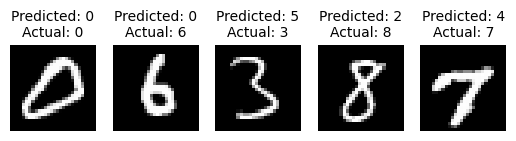

Accuracy on sample images: 0.20


In [51]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
import random

# Виберемо 5 випадкових зображень з тестового набору
num_images = 5
random_indices = random.sample(range(len(x_test)), num_images)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Передаємо зображення в нейронну мережу та отримуємо прогнози
predictions = neural_net(sample_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Відображаємо кожне тестове зображення та прогноз нейронної мережі
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}\nActual: {sample_labels[i]}", fontsize=10)
    plt.axis('off')

plt.show()

# Обчислюємо точність класифікації
accuracy = accuracy_score(sample_labels, predicted_labels)
print(f'Accuracy on sample images: {accuracy:.2f}')